## clothing-agnostic person representation (衣服无关的人物表示) 的获取过程

img list: ['datasets/test/image/10549_00.jpg', 'datasets/test/image/07573_00.jpg', 'datasets/test/image/00891_00.jpg', 'datasets/test/image/03615_00.jpg', 'datasets/test/image/08909_00.jpg', 'datasets/test/image/07445_00.jpg']


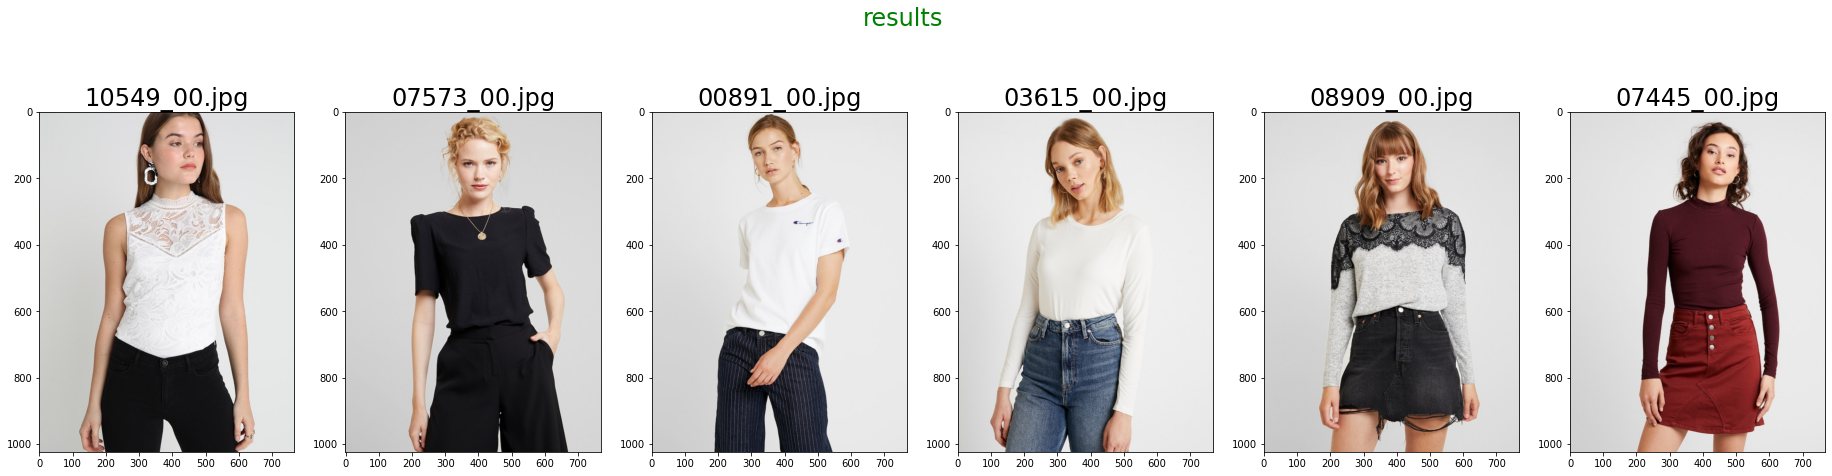

In [132]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from PIL import Image
import os.path as osp

def show_imgs(imgs, horizon=True, h=32, w=8):
    plt.figure(figsize=(h, w), dpi=72)
    plt.suptitle("results", fontsize=24, color='green')
    for i, img in enumerate(imgs):
        if horizon:
            sub_plt = plt.subplot(1, len(imgs), i+1)
        else:
            sub_plt = plt.subplot(len(imgs), 1, i+1)
        _, img_name = img.rsplit('/', 1)
        img = cv2.imread(img)
        sub_plt.imshow(img[:,:,::-1])
        sub_plt.set_title(img_name, fontsize=24)

img_root_dir = Path('./datasets')
imgs = [ str(i) for i in img_root_dir.glob('./test/image/*.jpg')]
print(f'img list: {imgs}')

show_imgs(imgs)

In [133]:
import torch
import torch.nn as nn

class opt:
    name = 'demo'
    batch_size = 1
    workers = 1
    load_height = 1024
    load_width = 768
    shuffle = False
    dataset_dir = './datasets/'
    dataset_mode = 'test'
    dataset_list = 'test_pairs.txt'
    checkpoint_dir = './checkpoints/'
    save_dir = './results/'
    display_freq = 1
    seg_checkpoint = 'seg_final.pth'
    gmm_checkpoint = 'gmm_final.pth'
    alias_checkpoint = 'alias_final.pth'
    
    # human-parsing map classes
    semantic_nc = 13
    init_type = 'xavier'
    init_variance = 0.02
    


In [134]:
from datasets import VITONDataset, VITONDataLoader
test_dataset = VITONDataset(opt)
test_loader = VITONDataLoader(opt, test_dataset)

/root/miniconda3/envs/jia/lib/python3.7/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [135]:
print(f"dataset path: {test_dataset.data_path}")
print(f"dataset images names: {test_dataset.img_names}")
print(f"dataset cloth names: {test_dataset.c_names}")
print(f"img H: {test_dataset.load_height} img W: {test_dataset.load_width}")
print(f"human parsing label nums: {test_dataset.semantic_nc}")

dataset path: ./datasets/test
dataset images names: ['08909_00.jpg', '00891_00.jpg', '03615_00.jpg', '07445_00.jpg', '07573_00.jpg', '10549_00.jpg']
dataset cloth names: {'unpaired': ['02783_00.jpg', '01430_00.jpg', '09933_00.jpg', '06429_00.jpg', '11791_00.jpg', '01260_00.jpg']}
img H: 1024 img W: 768
human parsing label nums: 13


## 拆解 Dataset 步骤
* **目的:** 得到 Agnostic Parsing and Agnostic Image

(768, 1024)


/root/miniconda3/envs/jia/lib/python3.7/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


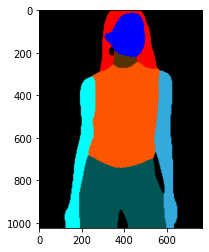

In [136]:
from torchvision.transforms import transforms
import numpy as np
from PIL import Image, ImageDraw

image_name = '10549_00'
parse = Image.open(f'./datasets/test/image-parse/{image_name}.png')
parse = transforms.Resize(test_dataset.load_width, interpolation=0)(parse)
print(parse.size)
plt.imshow(parse)

In [137]:
# get pose_data from openpose-json
import json
with open(f'./datasets/test/openpose-json/{image_name}_keypoints.json', 'r') as f:
    pose_label = json.load(f)
    pose_data = pose_label['people'][0]['pose_keypoints_2d']
    pose_data = np.array(pose_data)
    # opense pose 指示图: https://github.com/jiaqianjing/openpose/blob/master/doc/02_output.md#ui-and-visual-output
    pose_data = pose_data.reshape((-1, 3))[:,:2] # [25, 2], 即 25 个姿势关键点的坐标 (x, y)
    print(pose_data)

[[459.601  122.446 ]
 [411.38   346.137 ]
 [249.881  351.89  ]
 [215.974  615.468 ]
 [167.632  884.596 ]
 [572.94   329.271 ]
 [578.538  589.942 ]
 [615.365  859.147 ]
 [385.882  799.619 ]
 [283.831  799.629 ]
 [  0.       0.    ]
 [  0.       0.    ]
 [487.867  808.132 ]
 [  0.       0.    ]
 [  0.       0.    ]
 [414.197   99.5344]
 [479.43    99.5425]
 [329.241  125.35  ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]
 [  0.       0.    ]]


parse_agnostic size: (768, 1024)
torch.Size([1, 1024, 768])


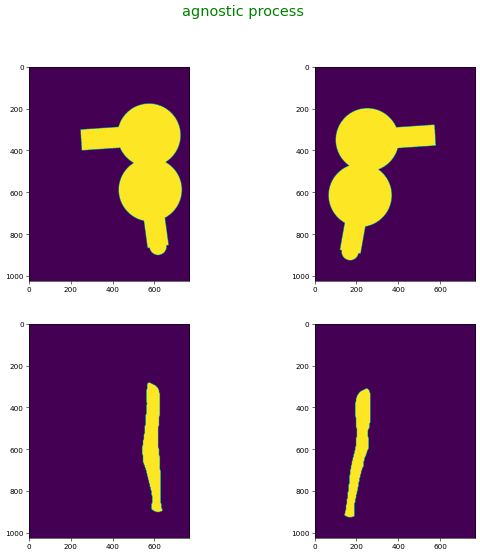

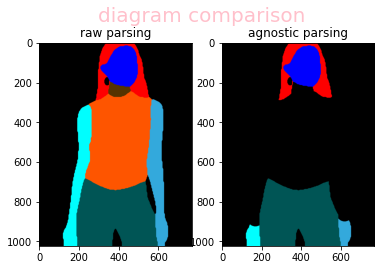

In [138]:
# ========================================================================
# pose_data: 根据 openpose 得到姿态关键点的坐标（25 个关键点）
# parse: PGN-humanparsing 语义分割图（P 模式的 8 bit 调色板图）
# ========================================================================
def get_parse_agnostic(load_width: int, load_height: int, parse: Image, pose_data: np.array):
    """
    human parsing label:
        0 background    10 tosor-skin
        1 hat           11 scarf
        2 hair          12 skirt
        3 glove         13 face
        4 sunglasses    14 leftArm
        5 upperclothes  15 rightArm
        6 dress         16 leftLeg
        7 coat          17 rightLeg
        8 socks         18 leftShoe
        9 pants         19 rightShoe
    """
    parse_array = np.array(parse)
    parse_upper = ((parse_array == 5).astype(np.float32) +
                   (parse_array == 6).astype(np.float32) +
                   (parse_array == 7).astype(np.float32))
    parse_neck = (parse_array == 10).astype(np.float32)

    r = 10
    agnostic = parse.copy()

    # mask arms (移除左右手臂， human parsing 中标签值 14， 15 分别代表 leftArm/rightArm, pose_data 中下标 2,3,4,5,6,7 为手臂的关键点)
    mask_arms = []
    parse_arms = []
    for parse_id, pose_ids in [(14, [2, 5, 6, 7]), (15, [5, 2, 3, 4])]:
        mask_arm = Image.new('L', (load_width, load_height), 'black')
        # 2D 编辑图像函数, 用于编辑上面创建 mask_arm 图片
        mask_arm_draw = ImageDraw.Draw(mask_arm)
        i_prev = pose_ids[0]
        for i in pose_ids[1:]:
            if (pose_data[i_prev, 0] == 0.0 and pose_data[i_prev, 1] == 0.0) or (pose_data[i, 0] == 0.0 and pose_data[i, 1] == 0.0):
                continue
            mask_arm_draw.line([tuple(pose_data[j]) for j in [i_prev, i]], 'white', width=r*10)
            pointx, pointy = pose_data[i]
            radius = r*4 if i == pose_ids[-1] else r*15
            mask_arm_draw.ellipse((pointx-radius, pointy-radius, pointx+radius, pointy+radius), 'white', 'white')
            i_prev = i
            
        # 暂存根据 pose_data 选中左右手臂的区域，用于可视化
        mask_arms.append(mask_arm)
        
        
        # 取 mask_arm（不含手的信息） 和 human parsing 左右手臂（含手的信息）交集的部分（为了保留手的信息）
        parse_arm = (np.array(mask_arm) / 255) * (parse_array == parse_id).astype(np.float32)
        parse_arm_img = Image.fromarray(np.uint8(parse_arm * 255), 'L')
        parse_arms.append(parse_arm_img)
 
       
        # 仅对 mask 中为 255 像素值的位置进行复制，为 0 像素值的位置，保持原图
        agnostic.paste(im=0, box=None, mask=parse_arm_img)

    # mask torso & neck (移除 humanparsing 的上身躯干和脖子) 
    # im 为要复制的图像（全黑），仅对 mask 中为 255 像素值的位置进行复制，为 0 像素值的位置，保持原图
    agnostic.paste(im=0, box=None, mask=Image.fromarray(np.uint8(parse_upper * 255), 'L'))
    agnostic.paste(im=0, box=None, mask=Image.fromarray(np.uint8(parse_neck * 255), 'L'))

    # visual mask process
    fig = plt.figure(figsize=(13, 12), dpi=52)
    plt.suptitle("agnostic process",  fontsize=20, color='green')
    for i, img in enumerate(mask_arms+parse_arms):
        plt.subplot(2, 2, i+1)
        plt.imshow(img)
    
    return agnostic

# =======================================================
# 获取 agnostic 语义分割图；移除手臂、脖子、上身躯干（保留手）
# =======================================================
parse_agnostic = get_parse_agnostic(768, 1024, parse, pose_data)
print(f'parse_agnostic size: {parse_agnostic.size}')

new_fig = plt.figure()
plt.suptitle("diagram comparison", fontsize=20, color='pink')
plt.subplot(1, 2, 1)
plt.title("raw parsing")
plt.imshow(parse)
plt.subplot(1, 2, 2)
plt.title("agnostic parsing")
plt.imshow(parse_agnostic)
parse_agnostic = torch.from_numpy(np.array(parse_agnostic)[np.newaxis,:]).long()
print(parse_agnostic.shape)

In [139]:
# ========================================================================
# Human Parsing(num_class=20) -> VITON Parsing (num_class=13) & One-Hot
# ========================================================================
labels = {
    0: ['background', [0, 10]],  # background, tosor-skin
    1: ['hair', [1, 2]],         # hat, hair
    2: ['face', [4, 13]],        # sunglasses, face
    3: ['upper', [5, 6, 7]],     # upperclothes, dress, coat
    4: ['bottom', [9, 12]],      # pants, skirt
    5: ['left_arm', [14]],       # leftArm
    6: ['right_arm', [15]],      # rightArm
    7: ['left_leg', [16]],       # leftLeg
    8: ['right_leg', [17]],      # rightLeg
    9: ['left_shoe', [18]],      # leftShoe
    10: ['right_shoe', [19]],    # rightShoe
    11: ['socks', [8]],          # socks
    12: ['noise', [3, 11]]       # glove, scarf
}
# [20, 1024, 768] 
parse_agnostic_map = torch.zeros(20, test_dataset.load_height, test_dataset.load_width, dtype=torch.float)
parse_agnostic_map.scatter_(0, parse_agnostic, 1.0)

# [13, 1024, 768]
new_parse_agnostic_map = torch.zeros(test_dataset.semantic_nc, test_dataset.load_height, test_dataset.load_width, dtype=torch.float)
for i in range(len(labels)):
    for label in labels[i][1]:
        new_parse_agnostic_map[i] += parse_agnostic_map[label]

new_parse_agnostic_map.shape

torch.Size([13, 1024, 768])

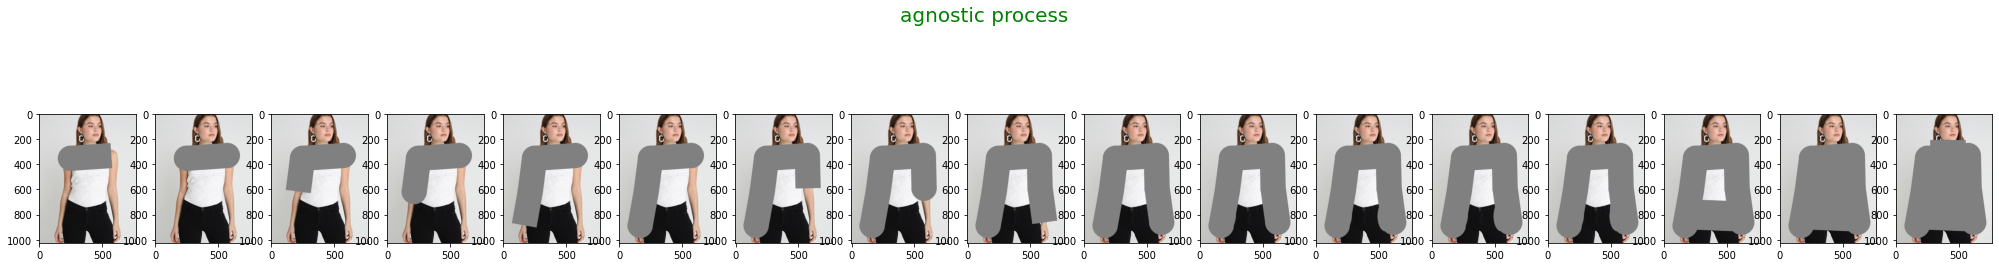

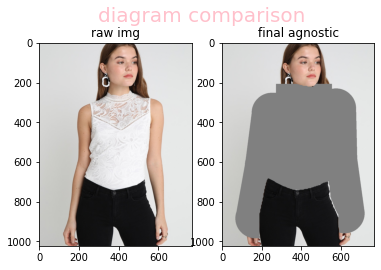

In [140]:
# ========================================================================
# 获取 agnostic person img
# ========================================================================
def get_img_agnostic(img, parse, pose_data):
    """
    human parsing label:
        0 background    10 tosor-skin
        1 hat           11 scarf
        2 hair          12 skirt
        3 glove         13 face
        4 sunglasses    14 leftArm
        5 upperclothes  15 rightArm
        6 dress         16 leftLeg
        7 coat          17 rightLeg
        8 socks         18 leftShoe
        9 pants         19 rightShoe
    """
    parse_array = np.array(parse)
    parse_head = ((parse_array == 4).astype(np.float32) +
                  (parse_array == 13).astype(np.float32))
    parse_lower = ((parse_array == 9).astype(np.float32) +
                   (parse_array == 12).astype(np.float32) +
                   (parse_array == 16).astype(np.float32) +
                   (parse_array == 17).astype(np.float32) +
                   (parse_array == 18).astype(np.float32) +
                   (parse_array == 19).astype(np.float32))

    r = 20
    agnostic = img.copy()
    agnostic_draw = ImageDraw.Draw(agnostic)

    length_a = np.linalg.norm(pose_data[5] - pose_data[2], ord=2) # l2 范数 (两点距离)
    length_b = np.linalg.norm(pose_data[12] - pose_data[9], ord=2) # l2 范数 (两点距离)
    point = (pose_data[9] + pose_data[12]) / 2
    pose_data[9] = point + (pose_data[9] - point) / length_b * length_a
    pose_data[12] = point + (pose_data[12] - point) / length_b * length_a

    # mask arms
    mid_draw = []
    agnostic_draw.line([tuple(pose_data[i]) for i in [2, 5]], 'gray', width=r*10)
    for i in [2, 5]:
        pointx, pointy = pose_data[i]
        agnostic_draw.ellipse((pointx-r*5, pointy-r*5, pointx+r*5, pointy+r*5), 'gray', 'gray')
        mid_draw.append(agnostic.copy())
    
    for i in [3, 4, 6, 7]:
        if (pose_data[i - 1, 0] == 0.0 and pose_data[i - 1, 1] == 0.0) or (pose_data[i, 0] == 0.0 and pose_data[i, 1] == 0.0):
            continue
        agnostic_draw.line([tuple(pose_data[j]) for j in [i - 1, i]], 'gray', width=r*10)
        mid_draw.append(agnostic.copy())
            
        pointx, pointy = pose_data[i]
        agnostic_draw.ellipse((pointx-r*5, pointy-r*5, pointx+r*5, pointy+r*5), 'gray', 'gray')
        mid_draw.append(agnostic.copy())

    # mask torso
    for i in [9, 12]:
        pointx, pointy = pose_data[i]
        agnostic_draw.ellipse((pointx-r*3, pointy-r*6, pointx+r*3, pointy+r*6), 'gray', 'gray')
        mid_draw.append(agnostic.copy())
    
    agnostic_draw.line([tuple(pose_data[i]) for i in [2, 9]], 'gray', width=r*6)
    mid_draw.append(agnostic.copy())
    
    agnostic_draw.line([tuple(pose_data[i]) for i in [5, 12]], 'gray', width=r*6)
    mid_draw.append(agnostic.copy())
    
    agnostic_draw.line([tuple(pose_data[i]) for i in [9, 12]], 'gray', width=r*12)
    mid_draw.append(agnostic.copy())
    
    agnostic_draw.polygon([tuple(pose_data[i]) for i in [2, 5, 12, 9]], 'gray', 'gray')
    mid_draw.append(agnostic.copy())

    # mask neck
    pointx, pointy = pose_data[1]
    agnostic_draw.rectangle((pointx-r*7, pointy-r*7, pointx+r*7, pointy+r*7), 'gray', 'gray')
    mid_draw.append(agnostic.copy())
    
    # 可视化 mask 的过程
    fig = plt.figure(figsize=(35, 5), dpi=72)
    plt.suptitle("agnostic process", fontsize=20, color='green')
    for i, mid_img in enumerate(mid_draw):
        plt.subplot(1, len(mid_draw), i+1)
        plt.imshow(mid_img)
    
    agnostic.paste(img, None, Image.fromarray(np.uint8(parse_head * 255), 'L'))
    agnostic.paste(img, None, Image.fromarray(np.uint8(parse_lower * 255), 'L'))
         
    return agnostic

img = Image.open(f'./datasets/test/image/{image_name}.jpg')   
img = transforms.Resize(test_dataset.load_width, interpolation=2)(img)


img_agnostic = get_img_agnostic(img, parse, pose_data)

fig = plt.figure()
plt.suptitle("diagram comparison", fontsize=20, color='pink')
plt.subplot(1,2,1)
plt.title("raw img")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("final agnostic")
plt.imshow(img_agnostic)

## 浏览 dataset 单个数据

In [141]:
from datasets import VITONDataset, VITONDataLoader
test_dataset = VITONDataset(opt)
test_loader = VITONDataLoader(opt, test_dataset)

# 取 dataset 中第一个数据
img_name = test_dataset[0]['img_name']
c_name = test_dataset[0]['c_name']
img = test_dataset[0]['img']
img_agnostic = test_dataset[0]['img_agnostic']
parse_agnostic = test_dataset[0]['parse_agnostic']
pose = test_dataset[0]['pose']
cloth = test_dataset[0]['cloth']
cloth_mask = test_dataset[0]['cloth_mask']

In [145]:
print(f'img_name: {img_name}')
print(f'c_name: {c_name}')
print(f'img shape: {img.shape}')
print(f'img_agnostic shape: {img_agnostic.shape}')
print(f'parse_agnostic shape: {parse_agnostic.shape}')
print(f'pose rgb: {pose.shape}')
print(f'cloth shape:', cloth['unpaired'].shape)
print(f'cloth_mask:', cloth_mask['unpaired'].shape)

img_name: 08909_00.jpg
c_name: {'unpaired': '02783_00.jpg'}
img shape: torch.Size([3, 1024, 768])
img_agnostic shape: torch.Size([3, 1024, 768])
parse_agnostic shape: torch.Size([13, 1024, 768])
pose rgb: torch.Size([3, 1024, 768])
cloth shape: torch.Size([3, 1024, 768])
cloth_mask: torch.Size([1, 1024, 768])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'cloth_mask')

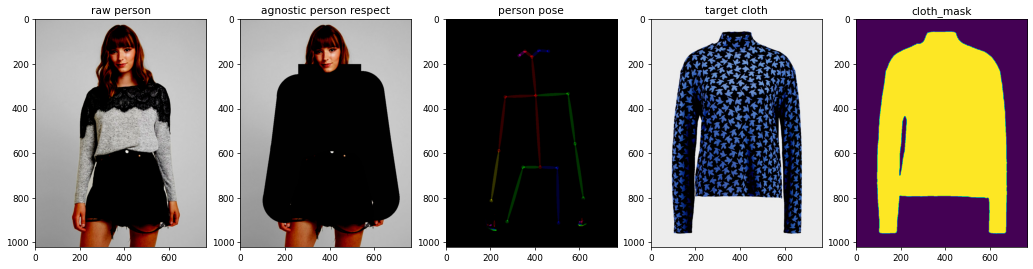

In [146]:
# 因为都进行了归一化(像素值缩放到 [-1, 1])，所以整体图像偏暗
figure = plt.figure(figsize=(20, 15), dpi=64)

subplot = figure.add_subplot(1,5,1)
subplot.imshow(img.permute(1,2,0))
subplot.set_title("raw person")

subplot = figure.add_subplot(1,5,2)
subplot.imshow(img_agnostic.permute(1,2,0))
subplot.set_title("agnostic person respect")

subplot = figure.add_subplot(1,5,3)
subplot.imshow(pose.permute(1,2,0))
subplot.set_title("person pose")

subplot = figure.add_subplot(1,5,4)
subplot.imshow(cloth['unpaired'].permute(1,2,0))
subplot.set_title("target cloth")

subplot = figure.add_subplot(1,5,5)
subplot.imshow(cloth_mask['unpaired'].permute(1,2,0))
subplot.set_title("cloth_mask")

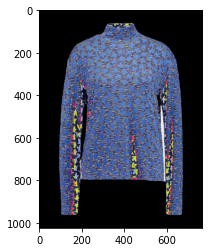

In [147]:
from torchvision.transforms.functional import to_pil_image
# 目标衣物去除背景
c_masked = cloth['unpaired'] * cloth_mask['unpaired']
plt.imshow(to_pil_image(c_masked))

In [148]:
def gen_noise(shape):
    noise = np.zeros(shape, dtype=np.uint8)
    ### noise
    noise = cv2.randn(noise, 0, 255)
    noise = np.asarray(noise / 255, dtype=np.uint8)
    noise = torch.tensor(noise, dtype=torch.float32)
    return noise
gen_noise([1, 1, 6, 6])

tensor([[[[1., 1., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0.],
          [0., 1., 1., 0., 0., 1.]]]])

## Huamn parsing(part segmentation)

color map len: 768
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  2 13 13 13  2  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2 13 13 13 13  2  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  2  2 13 13 13  2  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  2  2 13 13 10  2  2  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  2  2 10 10 10  2  2  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  2  2 10 10 10 10  2  2  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  

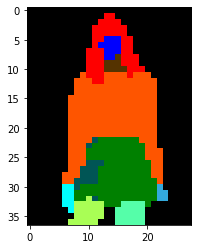

In [149]:
# load demo parsing image
# 8 bit 调色板
parse = Image.open('./datasets/test/image-parse/08909_00.png').convert('P')
color_map = parse.getpalette()
print(f"color map len: {len(color_map)}") # 255 * 3 可用于 255 个颜色标记不同的语义标签 

parse = transforms.Resize(28, interpolation=1)(parse)

parse_array = np.array(parse)

np.set_printoptions(edgeitems=50, linewidth=200)
print(parse_array)
print(parse_array.shape)
plt.imshow(parse)

In [150]:
import pickle

# 保留 human parsing 的标签调色板信息到本地文件
with open('colormap.pkl', 'wb') as file:    #注意二进制写入
    pickle.dump(color_map, file)
